<a href="https://colab.research.google.com/github/ghostwalkin/Handwriting-analyser/blob/main/HandwritingOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting up working directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/ocr_hw'

/content/gdrive/MyDrive/ocr_hw


In [3]:
!pwd

/content/gdrive/MyDrive/ocr_hw


In [4]:
!ls

handwriting_recognizer.h5  image_dataset.zip  image_unzipped  text_dataset.zip	text_unzipped


In [5]:
#!mkdir '/content/gdrive/MyDrive/ocr_hw/text_unzipped'

In [6]:
#!mkdir '/content/gdrive/MyDrive/ocr_hw/image_unzipped'

note: I have renamed the words and parser data files to "image_dataset.zip" and "text_dataset.zip" respectively for ease of use

In [7]:
#!unzip '/content/gdrive/MyDrive/ocr_hw/text_dataset.zip' -d '/content/gdrive/MyDrive/ocr_hw/text_unzipped'
#!unzip '/content/gdrive/MyDrive/ocr_hw/image_dataset.zip' -d '/content/gdrive/MyDrive/ocr_hw/image_unzipped'

#Preprocessing

##Dependencies

In [8]:
import os
import cv2
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


np.random.seed(42)
tf.random.set_seed(42)


In [9]:
!head -20 /content/gdrive/MyDrive/ocr_hw/text_unzipped/parser.txt

a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE
a01-000u-00-02 ok 154 796 764 70 50 TO to
a01-000u-00-03 ok 154 919 757 166 78 VB stop
a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.
a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell
a01-000u-00-06 ok 154 1896 757 173 72 IN from
a01-000u-01-00 ok 156 395 932 441 100 VBG nominating
a01-000u-01-01 ok 156 901 958 147 79 DTI any
a01-000u-01-02 ok 156 1112 958 208 42 AP more
a01-000u-01-03 ok 156 1400 937 294 59 NN Labour
a01-000u-01-04 ok 156 1779 932 174 63 NN life
a01-000u-01-05 ok 156 2008 933 237 70 NNS Peers
a01-000u-02-00 ok 157 408 1106 65 70 BEZ is
a01-000u-02-01 ok 157 541 1118 72 54 TO to
a01-000u-02-02 ok 157 720 1114 113 63 BE be
a01-000u-02-03 ok 157 916 1136 281 46 VBN made
a01-000u-02-04 ok 157 1281 1117 80 59 IN at
a01-000u-02-05 ok 157 1405 1140 64 35 AT a
a01-000u-02-06 ok 157 1544 1115 339 96 NN meeting


In [10]:
with open('/content/gdrive/MyDrive/ocr_hw/text_unzipped/parser.txt', 'r') as f:
  lines = f.readlines()
okimages=[]
image_id=[]
labels=[]

for line in lines:
      if line[0]=='#':
        continue
      if line.split(" ")[1]!='err':
        okimages.append(line)

print(len(okimages))

np.random.shuffle(okimages)

96456


## Creating folder paths and reading images from path

In [11]:
base_image_path = '/content/gdrive/MyDrive/ocr_hw/image_unzipped/words'

def image_path_labels(samples):
  path=[]
  labels=[]
  for i,line in enumerate(samples):
    clean_line=line.strip().split(" ")


    image_name=clean_line[0]+'.png'
    partI=image_name.split("-")[0]
    partII=image_name.split("-")[0]+'-'+image_name.split("-")[1]

    image_path = os.path.join(base_image_path, partI, partII, image_name)
    if os.path.exists(image_path):
       path.append(image_path)
       labels.append(clean_line[-1])
    else:
      pass

  return pd.DataFrame({'path':path,'label':labels})


In [12]:
df=image_path_labels(okimages)

As we got the list of paths and labels for exsisting images, next course of action is to prepare the images and texts for training

In [13]:
df.head()

,path,label
0,/content/gdrive/MyDrive/ocr_hw/image_unzipped/...,sure
1,/content/gdrive/MyDrive/ocr_hw/image_unzipped/...,he
2,/content/gdrive/MyDrive/ocr_hw/image_unzipped/...,The
3,/content/gdrive/MyDrive/ocr_hw/image_unzipped/...,and
4,/content/gdrive/MyDrive/ocr_hw/image_unzipped/...,his


In [14]:
len(okimages)

96456

In [15]:
df.shape

(18254, 2)

we had the length of the labels in text dataset 96456;but when we added the okaimages to get the paths and labels of the existing images in the directory, the shape of the resulting csv became (18254, 2); so as the length is significantly smaller; we need to split the sataset again from the new exsisting data i.e 'df' and then preprocess the data for training.





## Splitting dataset


In [16]:
from sklearn.model_selection import train_test_split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_df, test_val_df= train_test_split(df, test_size=(val_ratio + test_ratio), random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

assert len(train_df) + len(val_df) + len(test_df) == len(df)


(14603, 2)
(1825, 2)
(1826, 2)


In [17]:
train_samples,train_labels=train_df.path.tolist(),train_df.label.tolist()
test_samples,test_labels=test_df.path.tolist(),test_df.label.tolist()
val_samples,val_labels=val_df.path.tolist(),val_df.label.tolist()

##preprocessing of images (distortion free resizing)

for resizing the image using tf.image.resize_with_pad function which will preserve the aspect ratio of the image and also add necesqtary padding

In [18]:
def resize(image,img_size):
  w,h=img_size
  image=tf.image.resize_with_pad(image,h,w)

  return image

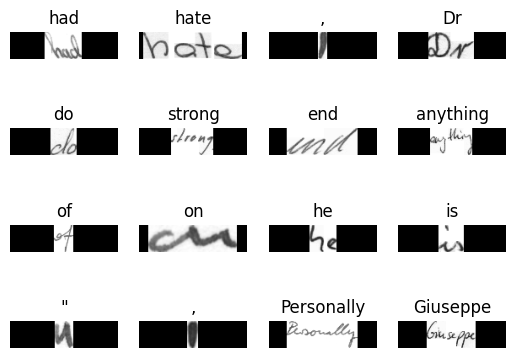

In [19]:
#testing above function
import matplotlib.pyplot as plt
import tensorflow as tf

for i in range(16):
    img_path = train_samples[i]
    label = train_labels[i]

    # Read and decode the image
    img_t = tf.io.read_file(img_path)
    img_t = tf.image.decode_png(img_t, 1)
    img_t=resize(img_t,(128,32))



    plt.subplot(4,4, i + 1)  # Create a 3x4 grid of subplots (adjust as needed)
    plt.imshow(img_t, cmap='gray')  # Assuming the image is grayscale
    plt.title(label)
    plt.axis('off')

plt.show()











##labels preprocessing

getting all the unique labels from the dataset

In [20]:
#labels preprocessing. we are doing this as for this project we need character level recognition. SO our goal is to get a vocabulary of all characters and convert them to vectors in further steps

labels = df.label.tolist()
label_set=set(labels)
characters=sorted(list(label_set))

print(len(characters))
vocab_size=len(characters)
characters[:10]

3090


['!', '"', '#', '&', "'", "'d", "'ll", "'m", "'re", "'s"]

In [21]:
max_len=0
for i in characters:
  if len(i)>max_len:
    max_len=len(i)

print(max_len)

17


In [22]:
for j in characters:
  if len(j)==max_len:
    print(j)
  else:
    pass

Marriage-Go-Round


as all the characters eg: m,r etc. aren't present uniquely in the dataset, for stringlookup vocabularies splliting all the labels to the character level and getting the integers

In [23]:
letters=[ ]

for letter in characters:
  for l in [*letter]:
    if l not in letters:
      letters.append(l)


In [24]:
new_vocab=letters+characters
new_vocab=list(set(new_vocab))
len(new_vocab)

3141

In [25]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

autotune=tf.data.AUTOTUNE

char_to_num=tf.keras.layers.StringLookup(vocabulary=new_vocab,mask_token=None)
num_to_char=tf.keras.layers.StringLookup(vocabulary=new_vocab,mask_token=None, invert=True)

In [26]:
a=char_to_num(tf.strings.unicode_split('beauty', 'UTF-8'))

In [27]:
np.array(a)

array([2783, 1588, 1587,  363, 2305, 1148])

In [28]:
int(tf.shape(a)[0])

6

In [29]:
tf.strings.reduce_join(num_to_char(a)).numpy().decode('utf-8')

'beauty'

##**preprocessing function with all the utilities**

In [30]:
max_len=max_len
vocab_size=vocab_size
padding_token=0
image_width=128
image_height=32
batch_size=48

def preprocess_image(image_path,image_size=(image_width,image_height)):
  image=tf.io.read_file(image_path)
  image=tf.image.decode_png(image, 1)
  image=resize(image,image_size)
  image=tf.cast(image, tf.float32)/255.0
  return image

def text_vec(label):
  label=char_to_num(tf.strings.unicode_split(label, 'UTF-8'))
  length=int(tf.shape(label)[0])
  padding=max_len-length
  label=tf.pad(label, [[0, padding]], constant_values=padding_token)
  return label

def process_image_label(image_path,label):
  image=preprocess_image(image_path)
  label=text_vec(label)
  return {'image':image,'label':label}

def prepare_dataset(image_paths,labels):
  dataset=tf.data.Dataset.from_tensor_slices((image_paths,labels)).map(process_image_label, num_parallel_calls=autotune)

  return dataset.batch(batch_size).prefetch(autotune)



#processed data


In [31]:
train_ds=prepare_dataset(train_samples,train_labels)
test_ds=prepare_dataset(test_samples,test_labels)
val_ds=prepare_dataset(val_samples,val_labels)

In [32]:
train_ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 32, 128, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

##visualize samples

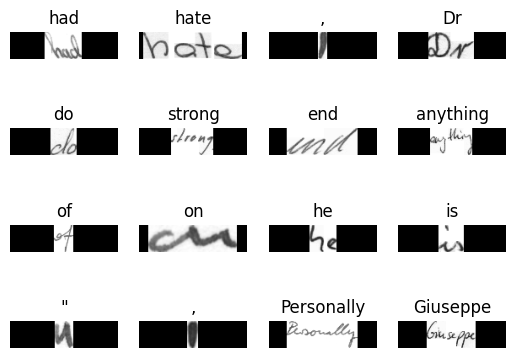

In [33]:
for data in train_ds.take(1):
  images,labels=data['image'],data['label']


  for i in range (16):

     img=images[i]


     label = labels[i]
     indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
     label = tf.strings.reduce_join(num_to_char(indices))
     label = label.numpy().decode("utf-8")

     plt.subplot(4,4,i+1)
     plt.imshow(img,cmap='gray')
     plt.title(label)
     plt.axis('off')
  plt.show()


#Finally, OCR model

In [34]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_height,image_width, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)


    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 32, 128, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 16, 64, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 16, 64, 64)           18496     ['pool1[0][0]']               
                                                                             

In [35]:
validation_images = []
validation_labels = []

for batch in val_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [36]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

##training the model

In [ ]:
epochs = 60  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/60
1/1 [==============================] - 0s 51ms/step
Mean edit distance for epoch 1: 14.9733
305/305 [==============================] - 1413s 5s/step - loss: 42.2091 - val_loss: 28.3532
Epoch 2/60
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 2: 14.6047
305/305 [==============================] - 57s 187ms/step - loss: 27.2437 - val_loss: 26.1220
Epoch 3/60
1/1 [==============================] - 0s 20ms/step
Mean edit distance for epoch 3: 14.6154
305/305 [==============================] - 60s 197ms/step - loss: 25.9888 - val_loss: 25.8944
Epoch 4/60
1/1 [==============================] - 0s 35ms/step
Mean edit distance for epoch 4: 3.5876
305/305 [==============================] - 57s 186ms/step - loss: 25.0150 - val_loss: 19.6289
Epoch 5/60
1/1 [==============================] - 0s 37ms/step
Mean edit distance for epoch 5: 3.4177
305/305 [==============================] - 116s 380ms/step - loss: 14.9077 - val_loss: 13.9663
Epoch 6/60
1/1 [=

##testing predictions

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, 0)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]


        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
model.save("handwriting_recognizer.h5")

In [ ]:
model.save("handwriting_recognizer.k")